##### Fashion Retailer needs to set Marketing Budget for New Branch in particular Country, and needs to forecast the Customer Revenue in the next year
##### Retailer seeks to identify high-value customers – customers, that are expected to bring high revenue to the retailer
##### The key idea is that a predictive model can be employed to predict the next year's revenue of the customer based on the previous year's purchases. 

In [91]:
# Import the required libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import datetime as dt 
import warnings
from sklearn.linear_model import LinearRegression, ridge_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler , PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.metrics import silhouette_score , mean_squared_error , mean_absolute_error
from sklearn.model_selection import cross_val_score , cross_validate

### historical transaction data for the years 2019 and 2020

In [92]:
file = "C:\\Users\\Mohannad.dawood\\Desktop\\Data_science_Projects\\retail_transactions.csv"
historical_data = pd.read_csv (file)
historical_data.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,546729,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2020-03-16 11:36:00,1.25,18231.0,United Kingdom
1,559898,21868,POTTING SHED TEA MUG,6,2020-07-13 12:18:00,1.25,16225.0,United Kingdom
2,548648,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2020-04-01 13:20:00,0.85,12949.0,United Kingdom
3,540543,22173,METAL 4 HOOK HANGER FRENCH CHATEAU,4,2020-01-09 15:23:00,2.95,14395.0,United Kingdom


In [93]:
# Let us discover our data 

historical_data.info()
historical_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  int64  
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 24.3+ MB


,InvoiceNo,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000,397884.000000
mean,560616.934451,12.988238,3.116488,15294.423453
std,13106.117773,179.331775,22.097877,1713.141560
min,536365.000000,1.000000,0.001000,12346.000000
25%,549234.000000,2.000000,1.250000,13969.000000
50%,561893.000000,6.000000,1.950000,15159.000000
75%,572090.000000,12.000000,3.750000,16795.000000
max,581587.000000,80995.000000,8142.750000,18287.000000


In [94]:
# from the above, we have 397884 records pf transactions and there is no missing data
# we need to modify the feature ( InvoiceDate) to date ,since time is too much information not necessary.  

In [95]:
historical_data['InvoiceDate']=pd.to_datetime(historical_data['InvoiceDate']).dt.date
historical_data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,546729,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2020-03-16,1.25,18231.0,United Kingdom
1,559898,21868,POTTING SHED TEA MUG,6,2020-07-13,1.25,16225.0,United Kingdom


In [96]:
# Transactions counts 18532 Invoices 
len(historical_data['InvoiceNo'].value_counts())

18532

In [97]:
# Products Counts 3877 Products , So we may study Fast Moving Items and high vlauable Products 
len(historical_data['Description'].value_counts())

3877

In [98]:
# Customers Counts 4338 Customers , so we may proceed with Customer segmentations , and Customer Life time value forecaste
len(historical_data['CustomerID'].value_counts())

4338

In [99]:
# Country Counts (37) Geografical locations , So we may Study Stock forecast to serve sales Foercast 
len(historical_data['Country'].unique())

37

- to forecast the revenue of next year, we need to form model of 2019 sales as independent features to forecast 2020 Revenue
- So we need to perform feature Engineering to set up the predictors which would help us to apply on next year depends on last year revenues. 

# Feature Engineering :
- we need to form the following features of 2019 to be applied on the model as independent features to find correlations with 2020 real revenues.
    - revenue_2019 (total revenue for the year 2019)
    - Days_since_first_purchase (the number of days since the first purchase by the customer)
    - Days_since_last_purchase (the number of days since the customer's most recent purchase)
    - Number_of_purchases (the total number of purchases by the customer in 2019)
    - Avg_order_cost (the average value of the orders placed by the customer in 2019)
    - revenue_2020 (the total revenue for the year 2020)


In [100]:
# Revenue_2019 could be obtained by Quantities * Unit Price for the total 18532 transactions in 2019
historical_data['Revenue'] = historical_data['Quantity'] * historical_data['UnitPrice']
operations = {'Revenue':'sum','InvoiceDate':'first','CustomerID':'first', 'Country':'first'}
historical_data = historical_data.groupby('InvoiceNo').agg(operations)
historical_data.head(2)

,Revenue,InvoiceDate,CustomerID,Country
InvoiceNo,,,,
536365,139.12,2019-12-01,17850.0,United Kingdom
536366,22.20,2019-12-01,17850.0,United Kingdom


In [101]:
# date of ( first Purchase) and ( last Purchase) and Number of Purchase 
historical_data['InvoiceDate']=pd.to_datetime(historical_data['InvoiceDate'])
historical_data['Year']=historical_data['InvoiceDate'].dt.year
historical_data['Period']= abs((dt.datetime(year=2019, month=12, day=31) - historical_data['InvoiceDate']).dt.days)
historical_data.head(2)

,Revenue,InvoiceDate,CustomerID,Country,Year,Period
InvoiceNo,,,,,,
536365,139.12,2019-12-01,17850.0,United Kingdom,2019,30
536366,22.20,2019-12-01,17850.0,United Kingdom,2019,30


### prepare the predictors dataframe (x) to be merged with prediction dataframe (y)

In [102]:
aggregation = {'Revenue':'sum','Period':['max','min','nunique']}
x= historical_data[historical_data['Year'] == 2019 ].groupby('CustomerID').agg(aggregation)
x.columns = [" ".join(col) for col in x.columns.values]
x.columns = ['Revenue 2019' , 'first order period', 'last order period', 'Orders count']
x['Average Order Value'] = x['Revenue 2019'] / x['Orders count']
x.head(4)

,Revenue 2019,first order period,last order period,Orders count,Average Order Value
CustomerID,,,,,
12347.0,711.79,24,24,1,711.79
12348.0,892.80,15,15,1,892.80
12370.0,1868.02,17,14,2,934.01
12377.0,1001.52,11,11,1,1001.52


In [103]:
aggregation_2020 = {'Revenue' : sum}
y = historical_data[historical_data['Year'] == 2020].groupby('CustomerID').agg(aggregation_2020)
y.columns = ['Rvenue 2020']
y.head(2)

,Rvenue 2020
CustomerID,
12346.0,77183.60
12347.0,3598.21


#### Merge X ( pridector data frame ) with y (prediction data frame ) to train machine learning model ( Simple Linear Regression )

In [104]:
ML_df = pd.merge(x,y, left_index=True , right_index=True,how='inner')
ML_df.head(3)

,Revenue 2019,first order period,last order period,Orders count,Average Order Value,Rvenue 2020
CustomerID,,,,,,
12347.0,711.79,24,24,1,711.79,3598.21
12348.0,892.80,15,15,1,892.80,904.44
12370.0,1868.02,17,14,2,934.01,1677.67


In [105]:
ML_df.shape

(766, 6)

### Remove the OUTLIERS from our our Data Frame

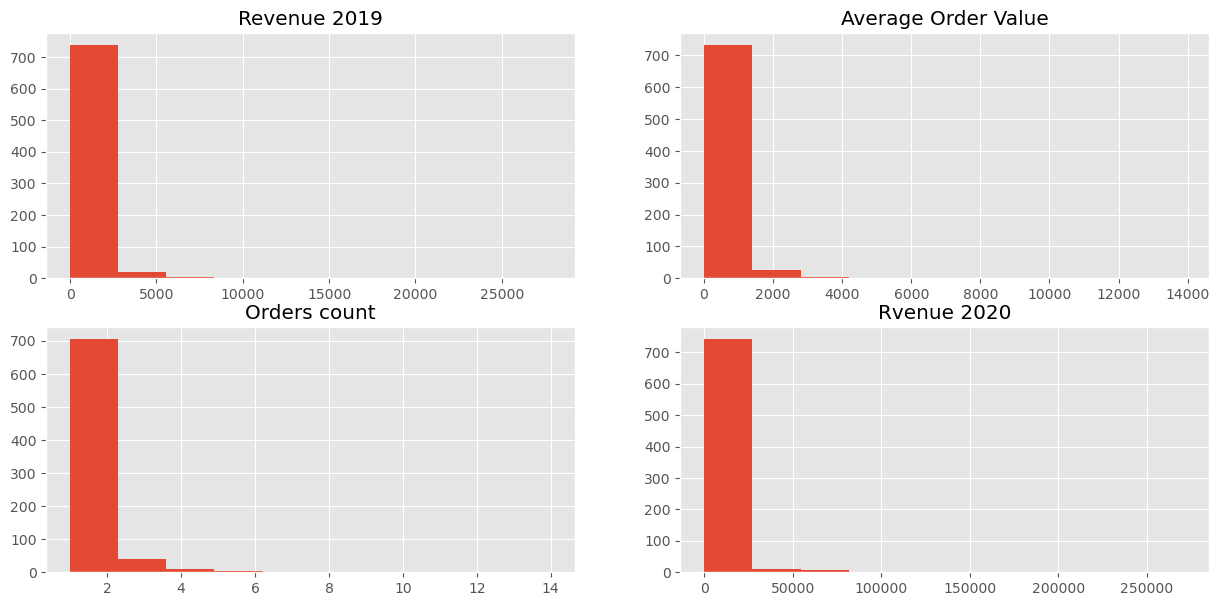

In [106]:
plt.style.use('ggplot')
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,7))
ax1.hist(ML_df['Revenue 2019'])
ax1.set_title ('Revenue 2019')
ax2.hist(ML_df['Average Order Value'])
ax2.set_title ('Average Order Value')
ax3.hist(ML_df['Orders count'])
ax3.set_title ('Orders count')
ax4.hist(ML_df['Rvenue 2020'])
ax4.set_title ('Rvenue 2020')
plt.show()

In [107]:
ML_df = ML_df[ML_df['Revenue 2019'] < ( ML_df['Revenue 2019'].median() +  ML_df['Revenue 2019'].std()*3)]
ML_df.shape

(757, 6)

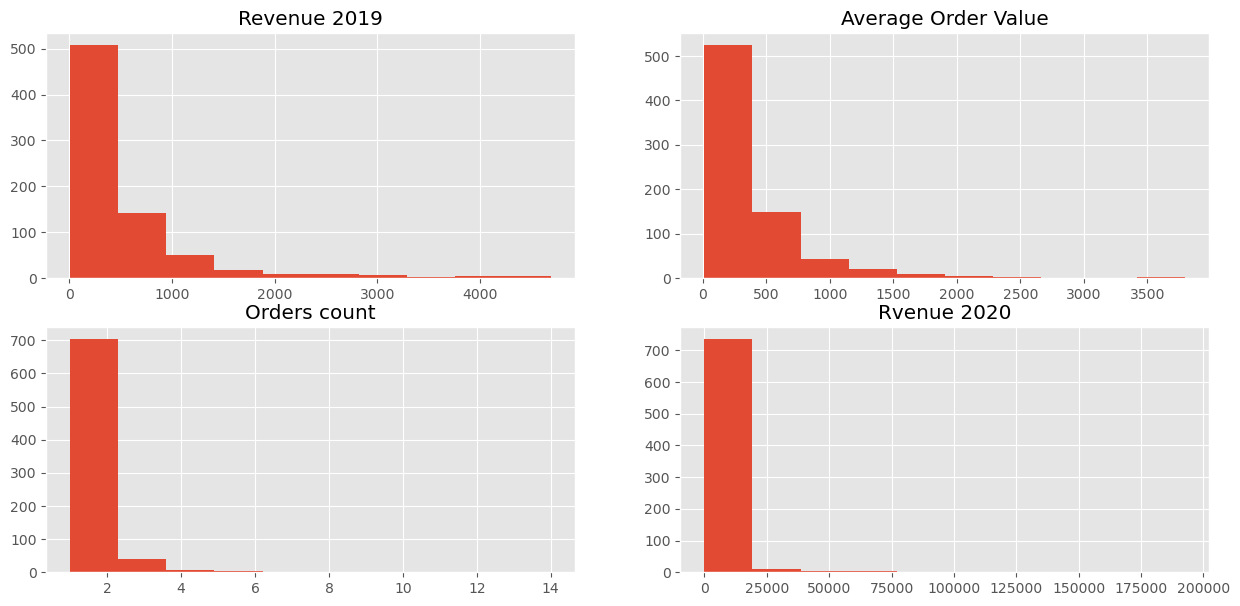

In [108]:
plt.style.use('ggplot')
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,7))
ax1.hist(ML_df['Revenue 2019'])
ax1.set_title ('Revenue 2019')
ax2.hist(ML_df['Average Order Value'])
ax2.set_title ('Average Order Value')
ax3.hist(ML_df['Orders count'])
ax3.set_title ('Orders count')
ax4.hist(ML_df['Rvenue 2020'])
ax4.set_title ('Rvenue 2020')
plt.show()

### Define the Correlations between Predictors and predictions value 

In [109]:
ML_df.corr()

,Revenue 2019,first order period,last order period,Orders count,Average Order Value,Rvenue 2020
Revenue 2019,1.000000,0.109268,-0.254705,0.483499,0.810552,0.410965
first order period,0.109268,1.000000,0.624892,0.295477,-0.045065,0.071319
last order period,-0.254705,0.624892,1.000000,-0.383827,-0.068305,-0.066846
Orders count,0.483499,0.295477,-0.383827,1.000000,0.017392,0.233498
Average Order Value,0.810552,-0.045065,-0.068305,0.017392,1.000000,0.333242
Rvenue 2020,0.410965,0.071319,-0.066846,0.233498,0.333242,1.000000


##### the higher the 2019 revenue from a customer, greater the expected revenue from them in 2020 should be. 
##### Negative numbers mean the reverse – for example, the more days there have been since a customer's last purchase, the lower you would expect the 2020 revenue from them to be. 
##### The correlation values agree that revenue_2019 has the strongest relationship with revenue_2020.

## will train a linear regression model with revenue_2020 as the dependent variable and the rest of the variables as the independent variables

In [135]:
X=ML_df[['Revenue 2019','last order period','Orders count', 'Average Order Value']]
X_scaled = StandardScaler().fit_transform(X)
Y = ML_df[['Rvenue 2020']]
Y_sclae = StandardScaler().fit_transform(Y).reshape(-1,1)
lr= LinearRegression()
cross_score = cross_val_score(lr,X_scaled,Y,cv=10,scoring='neg_mean_absolute_error')
-1*cross_score.mean()


3324.1151894447366

In [136]:
warnings.filterwarnings("ignore")
random= RandomForestRegressor()
random_score = cross_val_score(random,X_scaled,Y,cv=10,scoring='neg_mean_absolute_error')
-1*random_score.mean()

3537.7554702736843

In [137]:
tree_r= DecisionTreeRegressor()
tree_score = cross_val_score(lr,X_scaled,Y,cv=10,scoring='neg_mean_absolute_error')
-1*tree_score.mean()

3324.1151894447366